In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score



## Random Forest on PCA Results

In [6]:
# Directory setup
pca_dir = "../../data/pca_data/byBasin_pca"
result_dir = "../../data/performance_comparison"
plot_dir = "../../images/random_forest_plots/random_forest_withPCA"
predicted_data_dir = "../../data/predicted_data/random_forest_withPCA"
os.makedirs(plot_dir, exist_ok=True)
os.makedirs(predicted_data_dir, exist_ok=True)

# Get a list of PCA result files
pca_files = [f for f in os.listdir(pca_dir) if f.endswith('_pca_with_target.csv')]

# Dictionary for results
results = {}

# Parameters for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Process each PCA result file
for file in pca_files:
    basin_name = file.replace('_pca_with_target.csv', '').replace(' ', '_')  # Sanitize basin names
    pca_df = pd.read_csv(f"{pca_dir}/{file}")

    # Separate data into known and unknown 'Li' values
    known_data = pca_df.dropna(subset=['Li'])
    unknown_data = pca_df[pca_df['Li'].isnull()]

    # Prepare training and testing data
    principal_components = [f'PC{i+1}' for i in range(10)]
    X_known = known_data[principal_components]
    y_known = known_data['Li']
    X_train, X_test, y_train, y_test = train_test_split(X_known, y_known, test_size=0.2, random_state=42)

    # Initialize and perform GridSearchCV
    grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)

    # Get the best estimator
    best_rfr = grid_search.best_estimator_

    # Predict and evaluate
    y_pred = best_rfr.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    explained_variance = explained_variance_score(y_test, y_pred)

    # Store results
    results[basin_name] = {'MSE': mse, 'R2': r2, 'MAE': mae, 'RMSE': rmse, 'Explained Variance': explained_variance}
    print(f"Basin: {basin_name} - MSE: {mse}, R2: {r2}, MAE: {mae}, RMSE: {rmse}, Explained Variance: {explained_variance}")

    # Plot actual vs predicted and save
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    percentage_ranges = [5, 15, 25, 50]
    colors = ['lightblue', 'lightgreen', 'palegoldenrod', 'lightsalmon']
    for i, percentage in enumerate(percentage_ranges):
        threshold = (percentage / 100) * np.mean(y_test)
        plt.plot([y_test.min(), y_test.max()], [y_test.min() + threshold, y_test.max() + threshold], linestyle='--', color=colors[i], label=f'Within {percentage}%')
        plt.plot([y_test.min(), y_test.max()], [y_test.min() - threshold, y_test.max() - threshold], linestyle='--', color=colors[i])
    plt.xlabel('Actual Li concentrations')
    plt.ylabel('Predicted Li concentrations')
    plt.title(f'Actual vs. Predicted for {basin_name}')
    plt.legend()
    plot_path = os.path.join(plot_dir, f"{basin_name}_actual_predicted_random_forest_pca.png")
    plt.savefig(plot_path)
    plt.close()

    # Predict unknown 'Li' and save
    if not unknown_data.empty:
        X_unknown = unknown_data[principal_components]
        y_unknown_pred = best_rfr.predict(X_unknown)
        pca_df.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred

        # Save the complete DataFrame that includes both known and predicted 'Li' values
        complete_data_path = os.path.join(predicted_data_dir, f"{basin_name}_predicted_Li_random_forest_pca.csv")
        pca_df.to_csv(complete_data_path, index=False)

        # Plot distribution of predictions
        plt.figure(figsize=(10, 6))
        plt.hist(y_unknown_pred, bins=30, alpha=0.75)
        plt.xlabel('Predicted Lithium Concentration')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of Predicted Lithium Concentrations for New Samples in {basin_name}')
        plot_hist_path = os.path.join(plot_dir, f"{basin_name}_predicted_distribution_random_forest_pca.png")
        plt.savefig(plot_hist_path)
        plt.close()

# Convert results to a DataFrame and save
rf_results_df_with_pca = pd.DataFrame(results).T
rf_results_df_with_pca.to_csv(os.path.join(result_dir, "random_forest_performance_pca.csv"), index_label='Basin')

print("Saved performance metrics with PCA to CSV.")

Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Basin: Anadarko - MSE: 3899.6498734137326, R2: 0.6082757315185027, MAE: 18.265856880057427, RMSE: 62.44717666487199, Explained Variance: 0.6137425071146132
Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Basin: Appalachian - MSE: 1799.431032780529, R2: 0.507494617913804, MAE: 24.85954502044044, RMSE: 42.41970099824525, Explained Variance: 0.5221366519528992
Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Basin: Fort_Worth - MSE: 878.2869833687345, R2: 0.2833440371328968, MAE: 17.823436785714286, RMSE: 29.635906994197672, Explained Variance: 0.3930152528047798
Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Basin: Great_Plains - MSE: 40259.31954147454, R2: -0.07912930283451214, MAE: 57.355744486231146, RMSE: 200.6472515173695, Explained Variance: 0.005525299980461251
Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Basin: Gulf_Coast - MSE: 1069.6878201254776, R2: 0.8108865149065416, MAE: 14.551255494789551, RMSE: 32.70608231087113, Explained Variance: 0.8187572990663707
Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Basin: Illinois - MSE: 136.78371007806436, R2: 0.2846039669225895, MAE: 9.237887825396827, RMSE: 11.695456813569292, Explained Variance: 0.4097418266876558
Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Basin: Michigan - MSE: 126.77340006566425, R2: 0.6828487950031692, MAE: 7.924579665281649, RMSE: 11.259369434638169, Explained Variance: 0.6864688563167062
Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Basin: Oklahoma_Platform - MSE: 151.82736870756224, R2: 0.5166695344974945, MAE: 8.969311289425514, RMSE: 12.321824893560297, Explained Variance: 0.5536532259751188
Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Basin: Pacific - MSE: 9.856069683017248, R2: 0.048207000205723105, MAE: 1.68568908045977, RMSE: 3.139437797284292, Explained Variance: 0.04824719071834638
Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Basin: Permian - MSE: 4854.220069409181, R2: 0.04541676490457691, MAE: 15.456641112918069, RMSE: 69.67223313063232, Explained Variance: 0.05813306034915744
Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Basin: Rocky_Mountain - MSE: 93.39795662826019, R2: 0.5646120682548084, MAE: 4.370241780500263, RMSE: 9.664261825316002, Explained Variance: 0.5646545617057028
Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Basin: Williston - MSE: 801.4384572342688, R2: 0.6522871783103985, MAE: 13.224775087868013, RMSE: 28.30968839874909, Explained Variance: 0.6524720800683614
Saved performance metrics with PCA to CSV.


## Random Forest on Imputed Data without PCA

In [8]:
# Load the dataset with all basins
df = pd.read_csv("../../data/df_output/df_cleaned_imputed.csv")

# Output directories for plots and predictions
plot_dir = "../../images/random_forest_plots/random_forest_withoutPCA"
predicted_data_dir = "../../data/predicted_data/random_forest_withoutPCA"
result_dir = "../../data/performance_comparison"
os.makedirs(plot_dir, exist_ok=True)
os.makedirs(predicted_data_dir, exist_ok=True)

# Define features to use for predicting 'Li'
predictors = ['B', 'Ba', 'Br', 'HCO3', 'FeTot', 'K', 'Na', 'Cl', 'SO4', 'Mg', 'Ca', 'Sr', 'Zn', 'TDS', 'DEPTHUPPER']

# Dictionary to store results for each basin
results = {}

# Setup the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Process each basin category
for basin in df['BASIN_CATEGORY'].unique():
    sanitized_basin = basin.replace(' ', '_')  # Sanitize basin names
    df_basin = df[df['BASIN_CATEGORY'] == basin]

    known_data = df_basin.dropna(subset=['Li'])
    unknown_data = df_basin[df_basin['Li'].isnull()]

    X_known = known_data[predictors]
    y_known = known_data['Li']
    X_train, X_test, y_train, y_test = train_test_split(X_known, y_known, test_size=0.2, random_state=42)

    grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    best_rfr = grid_search.best_estimator_

    y_pred = best_rfr.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    explained_variance = explained_variance_score(y_test, y_pred)

    results[sanitized_basin] = {
        'MSE': mse, 'R2': r2, 'MAE': mae, 'RMSE': rmse, 'Explained Variance': explained_variance
    }

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    percentage_ranges = [5, 15, 25, 50]
    colors = ['lightblue', 'lightgreen', 'palegoldenrod', 'lightsalmon']
    for i, percentage in enumerate(percentage_ranges):
        threshold = (percentage / 100) * np.mean(y_test)
        plt.plot([y_test.min(), y_test.max()], [y_test.min() + threshold, y_test.max() + threshold], linestyle='--', color=colors[i], label=f'Within {percentage}%')
        plt.plot([y_test.min(), y_test.max()], [y_test.min() - threshold, y_test.max() - threshold], linestyle='--', color=colors[i])
    plt.xlabel('Actual Li concentrations')
    plt.ylabel('Predicted Li concentrations')
    plt.title(f'Actual vs. Predicted for {sanitized_basin} - Without PCA')
    plt.legend()
    plot_path = os.path.join(plot_dir, f"{sanitized_basin}_actual_predicted_random_forest_no_pca.png")
    plt.savefig(plot_path)
    plt.close()

    if not unknown_data.empty:
        X_unknown = unknown_data[predictors]
        y_unknown_pred = best_rfr.predict(X_unknown)
        unknown_data['Predicted_Li'] = y_unknown_pred
        df_basin.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred

        predicted_data_path = os.path.join(predicted_data_dir, f"{sanitized_basin}_predicted_Li_random_forest_no_pca.csv")
        df_basin.to_csv(predicted_data_path, index=False)

        plt.figure(figsize=(10, 6))
        plt.hist(y_unknown_pred, bins=30, alpha=0.75)
        plt.xlabel('Predicted Lithium Concentration')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of Predicted Lithium Concentrations for New Samples in {sanitized_basin} - Without PCA')
        plot_hist_path = os.path.join(plot_dir, f"{sanitized_basin}_predicted_distribution_random_forest_no_pca.png")
        plt.savefig(plot_hist_path)
        plt.close()

rf_results_df_without_pca = pd.DataFrame(results).T
rf_results_df_without_pca.to_csv(os.path.join(result_dir, "random_forest_performance_no_pca.csv"), index_label='Basin')

print("Saved performance metrics without PCA to CSV.")

Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\darvarir\AppData\Local\Temp\ipykernel_10164\1395671308.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_10164\1395671308.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\darvarir\AppData\Local\Temp\ipykernel_10164\1395671308.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_10164\1395671308.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\darvarir\AppData\Local\Temp\ipykernel_10164\1395671308.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_10164\1395671308.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\darvarir\AppData\Local\Temp\ipykernel_10164\1395671308.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_10164\1395671308.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\darvarir\AppData\Local\Temp\ipykernel_10164\1395671308.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_10164\1395671308.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\darvarir\AppData\Local\Temp\ipykernel_10164\1395671308.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_10164\1395671308.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\darvarir\AppData\Local\Temp\ipykernel_10164\1395671308.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_10164\1395671308.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\darvarir\AppData\Local\Temp\ipykernel_10164\1395671308.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_10164\1395671308.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\darvarir\AppData\Local\Temp\ipykernel_10164\1395671308.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_10164\1395671308.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\darvarir\AppData\Local\Temp\ipykernel_10164\1395671308.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_10164\1395671308.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\darvarir\AppData\Local\Temp\ipykernel_10164\1395671308.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_10164\1395671308.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\darvarir\AppData\Local\Temp\ipykernel_10164\1395671308.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_10164\1395671308.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

Saved performance metrics without PCA to CSV.


## Performance Comparison

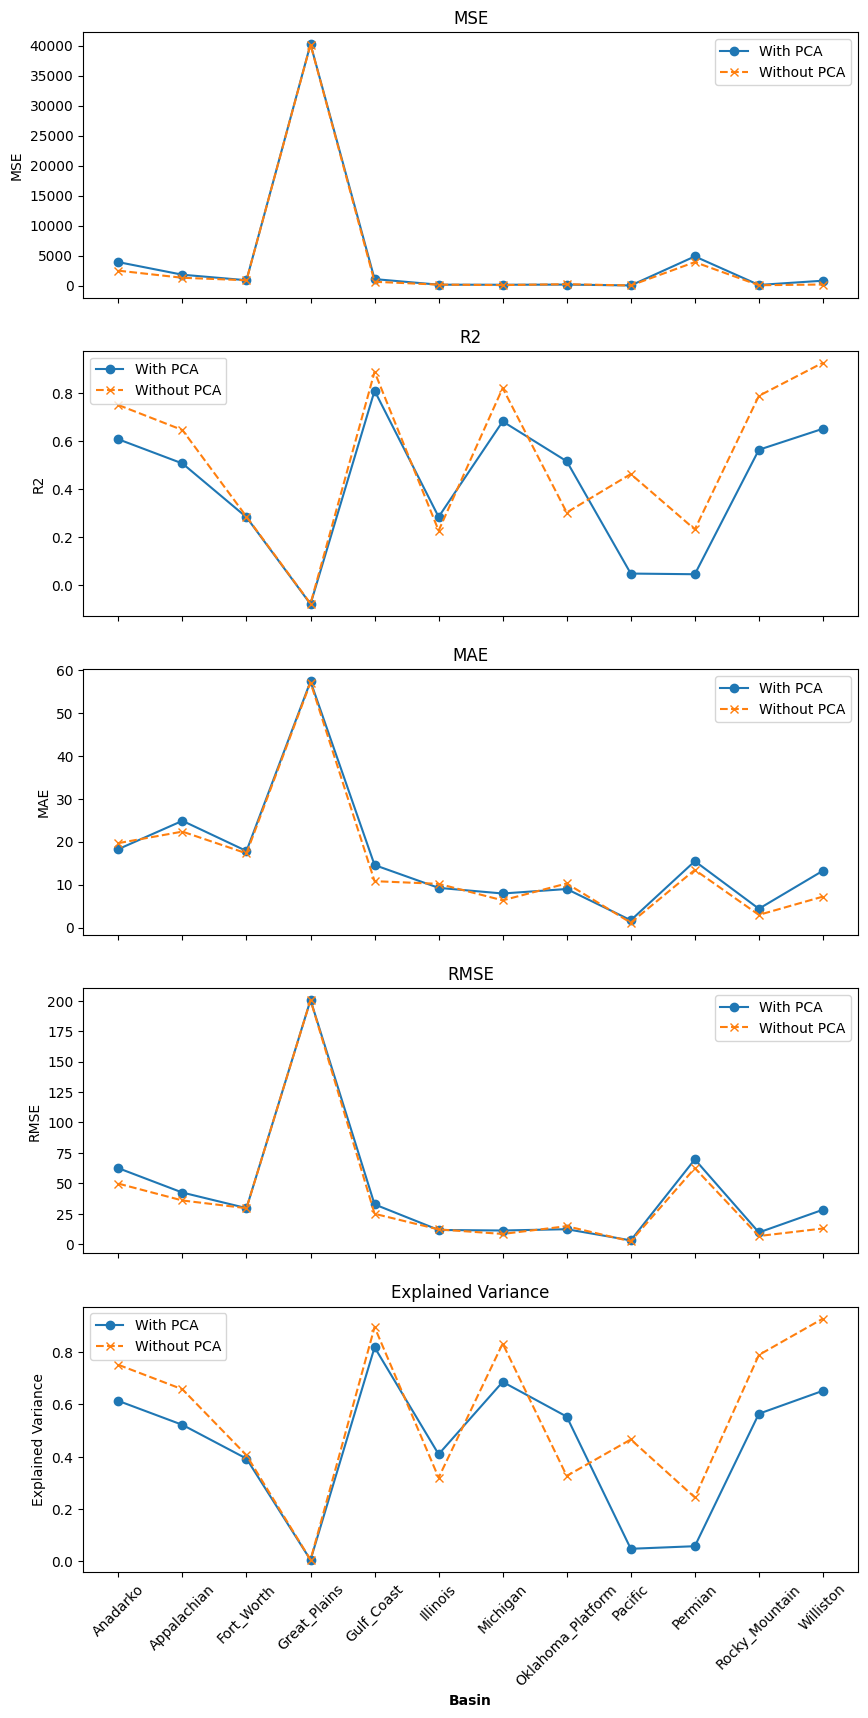

In [10]:
# Load results DataFrames
rf_results_df_with_pca = pd.read_csv("../../data/performance_comparison/random_forest_performance_pca.csv")
rf_results_df_without_pca = pd.read_csv("../../data/performance_comparison/random_forest_performance_no_pca.csv")

# Replace spaces with underscores in the basin names
rf_results_df_with_pca['Basin'] = rf_results_df_with_pca ['Basin'].str.replace(' ', '_')
rf_results_df_without_pca['Basin'] = rf_results_df_without_pca['Basin'].str.replace(' ', '_')

# Set 'Basin' as index now that the names are sanitized
rf_results_df_with_pca .set_index('Basin', inplace=True)
rf_results_df_without_pca.set_index('Basin', inplace=True)

# Merge the two results DataFrames
combined_results = rf_results_df_with_pca.join(rf_results_df_without_pca, lsuffix='_with_pca', rsuffix='_without_pca')

# Define the metrics to compare
metrics = ['MSE', 'R2', 'MAE', 'RMSE', 'Explained Variance']

# Create a figure and axes for the subplots
fig, axs = plt.subplots(nrows=len(metrics), ncols=1, figsize=(10, 20), sharex=True)

# Plot comparisons for each metric
for idx, metric in enumerate(metrics):
    axs[idx].plot(combined_results.index, combined_results[metric + '_with_pca'], marker='o', label='With PCA', linestyle='-')
    axs[idx].plot(combined_results.index, combined_results[metric + '_without_pca'], marker='x', label='Without PCA', linestyle='--')
    
    axs[idx].set_ylabel(metric)
    axs[idx].set_title(metric)
    axs[idx].legend()

# Set common labels
plt.xlabel('Basin', fontweight='bold')
plt.xticks(rotation=45)
plt.savefig("../../images/performance_comparison_plots/random_forest_performance_comparison.png")